In [1]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
from data_fetcher import extract_patches, get_line_data, get_padded_image, extract_patch
from type_tree import TypeTree as tt
import einops

/home/thetis/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/thetis/.local/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


- get images
- get point differences
- set up data pipeline
    - pass pairs of images
    - ensure image size is at least same size as point jumps
- Maybe only extract sections of images without opening the whole thing?

In [2]:
image = Image.open("./PointClicker/juneau2k.jpg")

to_tensor = transforms.ToTensor()
image_tensor = to_tensor(image)

size = 9
padding = size
padded_image_tensor = torch.nn.functional.pad(
    image_tensor, (padding, padding, padding, padding), "constant", value=1
)

/opt/miniconda3/lib/python3.10/site-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (122880000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [3]:
def old_extract_patch(tensor, x, y, size):
    x += padding
    y += padding
    return tensor[:, y - size : y + size, x - size : x + size]

In [4]:
x, y = 4447, 2554
patch = old_extract_patch(padded_image_tensor, x, y, size)
to_pil = transforms.ToPILImage()
patch_image = to_pil(patch)

In [5]:
patch.shape

torch.Size([3, 18, 18])

In [6]:
tt(patch)

Tensor (dtype: torch.float32)
    |__dim_0 (3)
    |__dim_1 (18)
    |__dim_2 (18)


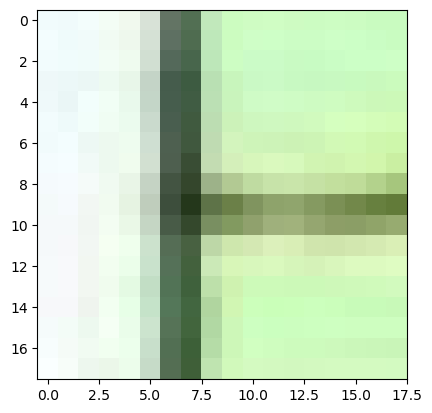

In [7]:
plt.imshow(patch_image)

In [8]:
df = pd.read_csv("juneau_points.csv", names=["index", "x", "y"])

In [9]:
points = df[df["index"] == 0]
x_tensor = torch.tensor(points["x"].values)
y_tensor = torch.tensor(points["y"].values)

final_tensor = torch.stack((x_tensor, y_tensor), dim=1)

In [10]:
final_tensor.shape

torch.Size([1372, 2])

In [11]:
ft = final_tensor.flatten()

In [12]:
ft.shape

torch.Size([2744])

In [13]:
for i, j in zip(final_tensor[:-1], final_tensor[1:]):
    print(j - i)

tensor([ 5.9358, -0.2827], dtype=torch.float64)
tensor([7.2078, 0.0000], dtype=torch.float64)
tensor([6.7838, 0.1413], dtype=torch.float64)
tensor([ 4.8052, -1.1306], dtype=torch.float64)
tensor([ 5.7932, -0.9128], dtype=torch.float64)
tensor([ 5.0907, -1.5353], dtype=torch.float64)
tensor([ 5.9796, -2.1817], dtype=torch.float64)
tensor([ 4.0403, -1.5353], dtype=torch.float64)
tensor([ 4.7675, -2.8282], dtype=torch.float64)
tensor([ 2.9898, -2.8282], dtype=torch.float64)
tensor([ 2.4242, -2.8282], dtype=torch.float64)
tensor([ 1.8585, -3.1514], dtype=torch.float64)
tensor([ 1.6161, -4.0403], dtype=torch.float64)
tensor([ 1.2929, -2.9090], dtype=torch.float64)
tensor([ 1.0505, -3.8786], dtype=torch.float64)
tensor([ 1.2929, -2.5050], dtype=torch.float64)
tensor([ 2.5858, -3.0706], dtype=torch.float64)
tensor([ 2.3433, -2.1817], dtype=torch.float64)
tensor([ 2.2625, -2.3433], dtype=torch.float64)
tensor([ 2.4242, -2.4242], dtype=torch.float64)
tensor([ 2.0201, -2.5050], dtype=torch.float

In [14]:
jumps = final_tensor[1:] - final_tensor[:-1]

In [15]:
torch.max(jumps.int().float())

tensor(8.)

In [16]:
lines = get_line_data([0], split=False)

In [17]:
tt(lines)

list: 1370
    |__tuple
        |__Tensor (dtype: torch.float64)
        |   |__dim_0 (2)
        |   |__dim_1 (2)
        |__Tensor (dtype: torch.float64)
            |__dim_0 (2)


In [18]:
(lines[0][0][1] - lines[0][0][0]).round()

tensor([ 6., -1.], dtype=torch.float64)

In [19]:
lines[2][1]

tensor([ 5., -2.], dtype=torch.float64)

In [20]:
im = get_padded_image("./juneau2k.jpg")

/opt/miniconda3/lib/python3.10/site-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (122880000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [21]:
tt(lines)

list: 1370
    |__tuple
        |__Tensor (dtype: torch.float64)
        |   |__dim_0 (2)
        |   |__dim_1 (2)
        |__Tensor (dtype: torch.float64)
            |__dim_0 (2)


In [22]:
lines[0][0][0]

tensor([4447., 2555.], dtype=torch.float64)

In [23]:
patch1 = extract_patch(im, lines[0][0][0], size, reshape=False)
patch2 = extract_patch(im, lines[0][0][1], size, reshape=False)
pos_3 = lines[0][1] + lines[0][0][1]
patch3 = extract_patch(im, pos_3, size, reshape=False)

tensor([4447, 2555], dtype=torch.int32)
tensor([4453, 2554], dtype=torch.int32)
tensor([4460, 2554], dtype=torch.int32)


In [24]:
tt(patch3)

Tensor (dtype: torch.float32)
    |__dim_0 (3)
    |__dim_1 (18)
    |__dim_2 (18)


In [25]:
def to_im(patch):
    return einops.rearrange(patch, "c h w -> h w c")

In [26]:
tt(patch1)

Tensor (dtype: torch.float32)
    |__dim_0 (3)
    |__dim_1 (18)
    |__dim_2 (18)


In [27]:
tt(patch_image)

Image


In [28]:
old_extract_patch

<function __main__.old_extract_patch(tensor, x, y, size)>

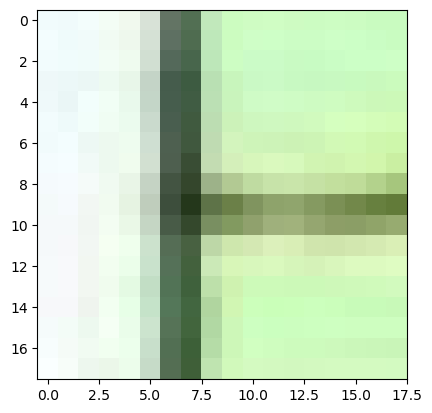

In [29]:
patch = old_extract_patch(padded_image_tensor, x, y, size)
plt.imshow(to_im(patch))

tensor([4447, 2554], dtype=torch.int32)
tensor([4447, 2555], dtype=torch.int32)
tensor([4453, 2554], dtype=torch.int32)
tensor([4460, 2554], dtype=torch.int32)


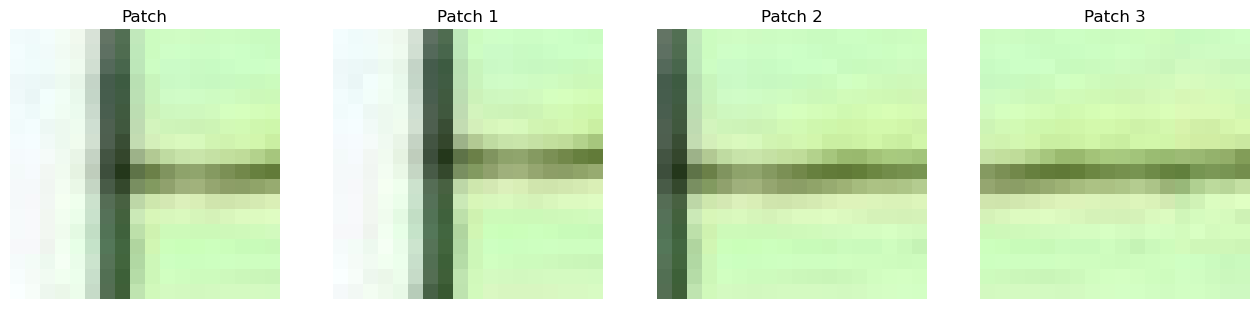

In [30]:
def to_im(patch):
    return einops.rearrange(patch, "c h w -> h w c")


x, y = 4447, 2554
patch = extract_patch(padded_image_tensor, torch.tensor([x, y]), size, reshape=False)
patch1 = extract_patch(padded_image_tensor, lines[0][0][0], size, reshape=False)
patch2 = extract_patch(padded_image_tensor, lines[0][0][1], size, reshape=False)
pos_3 = lines[0][1] + lines[0][0][1]
patch3 = extract_patch(padded_image_tensor, pos_3, size, reshape=False)
fig, axs = plt.subplots(1, 4, figsize=(16, 4))  # 1 row, 4 columns

axs[0].imshow(to_im(patch))
axs[0].set_title("Patch")

axs[1].imshow(to_im(patch1))
axs[1].set_title("Patch 1")

axs[2].imshow(to_im(patch2))
axs[2].set_title("Patch 2")

axs[3].imshow(to_im(patch3))
axs[3].set_title("Patch 3")

for ax in axs:
    ax.axis("off")

plt.show()

Text(0.5, 1.0, 'Patch 1')

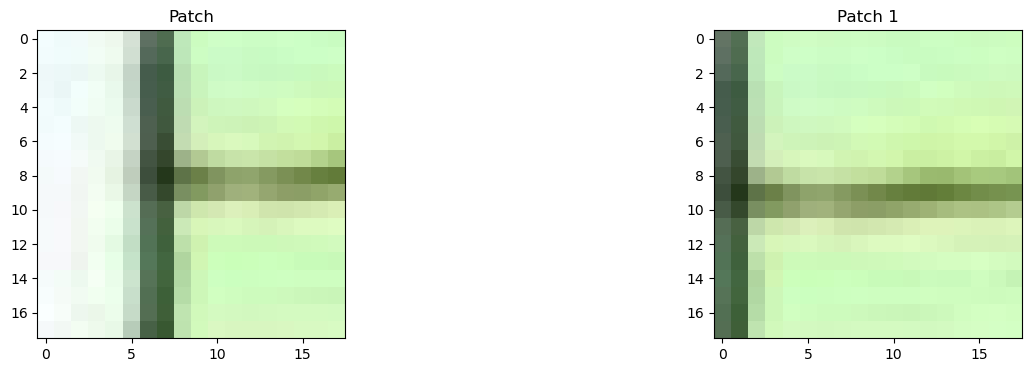

In [31]:
patches = extract_patches(padded_image_tensor, lines[0][0], size, reshape=False)

fig, axs = plt.subplots(1, 2, figsize=(16, 4))  # 1 row, 4 columns

axs[0].imshow(to_im(patches[0]))
axs[0].set_title("Patch")

axs[1].imshow(to_im(patches[1]))
axs[1].set_title("Patch 1")

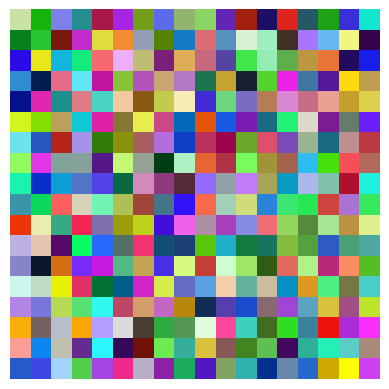

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Create a random 3x18x18 tensor to simulate your data
tensor = np.random.rand(3, 18, 18)

# Transpose the tensor to shape (18, 18, 3)
image_data = np.transpose(tensor, (1, 2, 0))

# Display the image
plt.imshow(image_data)
plt.axis("off")  # Turn off axis numbers and ticks
plt.show()